In [53]:
## Importing Libraries

# Python-based Libraries
from datetime import timedelta, datetime
from pathlib import Path
import os

# Data Analysis Libraries
import numpy as np
import pandas as pd
from haversine import haversine, Unit

# Graph plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mplcols
from matplotlib import cm
import folium
import branca.colormap as bcm

    
# Filtering Data before Plotting


In [54]:
class Drifters:
    
    def __init__(self, name:str):
        self.name = name
        self.data = {}
        self.data_info = {}
        
    def read_data(self, path):
        # Define Possible encodings
        encodings = ["UTF-8", "UTF-16 LE"]

        # Check if path is a filepath or directory path
        if Path(path).is_file(): 
            # Get file name from path
            filename = path.split('/')[-1].split('.')[-2] 
            # Define a variable to track file decoding
            encoding_gotten = False
            for encoding_value in encodings:
                try:
                    data_value = pd.read_csv(path, encoding=encoding_value)
                    # Catch special errors whereby the encoding is wrong but the data is read.
                    if "Unnamed: 1" in data_value.columns: 
                        continue
                    encoding_gotten = True
                    break # Stop trying if the options had worked
                except:
                    pass # Continue trying if the option didn't work

            if encoding_gotten == True:
                data_to_keep = [['DeviceDateTime','Latitude','Longitude'], 
                            ['Position time (UTC)', 'Latitude (°)', 'Longitude (°)'],
                            ]
                for dtk_val in data_to_keep:
                    try:
                        # Select Data to Keep
                        data_value = data_value[dtk_val]
                        # Drop columns with missing values
                        data_value.dropna()
                        # Rename Header Columns
                        data_value.columns = ['DateTime','Latitude','Longitude']
                        # Convert DateTime
                        data_value['DateTime'] = pd.to_datetime(data_value['DateTime'])
                        # Store DF in the object instance 'data'
                        self.data[filename] = data_value
                        
                    except:
                        pass
            else:
                print(f"Encoding error. The encoding for {filename} data should be checked.")

        elif Path(path).is_dir():    
        # 1. Read the files in the given path
            file_names = os.listdir(path)

            # 2. Read each file into pandas dataframe
            for file in file_names:
                filepath = path+'/'+file
                filename = file.split('.')[-2] 
                # Define a variable to track file decoding
                encoding_gotten = False
                for encoding_value in encodings:
                    try:
                        data_value = pd.read_csv(filepath, encoding=encoding_value)
                        # Catch special errors whereby the encoding is wrong but the data is read.
                        if "Unnamed: 1" in data_value.columns: 
                            continue
                        encoding_gotten = True
                        break # Stop trying if the options had worked
                    except:
                        pass # Continue trying if the option didn't work

                # Store the data in the "data" dictionary
                if encoding_gotten == True:
                    data_to_keep = [['DeviceDateTime','Latitude','Longitude'], 
                               ['Position time (UTC)', 'Latitude (°)', 'Longitude (°)'],
                                ]
                    for dtk_val in data_to_keep:
                        try:
                            # Select Data to Keep
                            data_value = data_value[dtk_val]
                            # Drop columns with missing values
                            data_value.dropna(axis=0, inplace=True)
                            # Rename Header Columns
                            data_value.columns = ['DateTime','Latitude','Longitude']
                            # Convert DateTime
                            data_value['DateTime'] = pd.to_datetime(data_value['DateTime'])
                            # Store DF in the object instance 'data'
                            self.data[filename] = data_value
                        
                        except:
                            pass

                else:
                    print(f"Encoding error. The encoding for {filepath} data should be checked.")
    
    def read_logsheet(self, file_path):
        
        self.logsheet = pd.read_csv(file_path)
        
        self.logsheet.dropna(axis=0, inplace=True)
        
        self.logsheet["DepDateTime"] = self.logsheet.apply(lambda x: str(x["DepDate"]) + " " + str(x["DepTime"]), axis = 1)
        self.logsheet["RecovDateTime"] = self.logsheet.apply(lambda x: str(x["RecovDate"]) + " " + str(x["RecovTime"]), axis = 1)
        
        self.logsheet.drop(columns=["DepDate", "DepTime", "RecovDate", "RecovTime"], inplace=True)
        
        self.logsheet["DepDateTime"] = pd.to_datetime(self.logsheet["DepDateTime"])
        self.logsheet["RecovDateTime"] = pd.to_datetime(self.logsheet["RecovDateTime"])
        
        names = self.logsheet["Name"]
        keys = [key for key in self.data.keys()]
        
        for key in keys:
            if float(key) not in list(names):
                self.data.pop(key)
                continue
            
            station = self.logsheet["Station"][self.logsheet["Name"] == float(key)].values
            drog_depth = self.logsheet["DrogDepth"][self.logsheet["Name"] == float(key)].values
            
            
            dep_datetime = self.logsheet["DepDateTime"][self.logsheet["Name"] == float(key)].values
            recov_datetime = self.logsheet["RecovDateTime"][self.logsheet["Name"] == float(key)].values
            
            dep_long = self.logsheet["DepLong"][self.logsheet["Name"] == float(key)].values
            dep_lat = self.logsheet["DepLat"][self.logsheet["Name"] == float(key)].values
            
            recov_long = self.logsheet["RecovLong"][self.logsheet["Name"] == float(key)].values
            recov_lat = self.logsheet["RecovLat"][self.logsheet["Name"] == float(key)].values
            
            
            info = {"Station":station, "DrogDepth":drog_depth, "DepDateTime":dep_datetime, "RecovDateTime":recov_datetime,
                    "DepLong":dep_long, "DepLat":dep_lat, "RecovLong":recov_long, "RecovLat":recov_lat}
            
            self.data_info[key] = info
    
    def time_shift(self, shift_amount:float = 1):
        for key in self.data.keys():
            self.data[key]["DateTime"] = self.data[key]["DateTime"] + timedelta(hours = shift_amount)
    
    def extract_data(self):
        for key in self.data_info.keys():
            # Get the start and end time for each experiment
            deploy_time = self.data_info[key]['DepDateTime']
            recov_time = self.data_info[key]['RecovDateTime']

            # Extract experiment data within the start and end time 
            bool = np.array([(deploy_time < pos_time < recov_time) for pos_time in self.data[key]["DateTime"]]).flatten()
            
            if bool.size != 0:
                self.data[key] = self.data[key][bool]
                # Drop columns with missing values
                self.data[key].dropna(axis=0, inplace=True)
            
        
    
    def compute_velocity(self, mov_avg = 1):
        R = 6373.0
        for key in self.data.keys():
            # Sort the DF by Ascending Datetime
            #self.data[key] = self.data[key].sort_values(by=["DateTime"])
            self.data[key].sort_values(by=["DateTime"], inplace=True)
            
            # select columns for latitude, longtitude and time
            df_lat = np.array(self.data[key]["Latitude"])
            df_long = np.array(self.data[key]["Longitude"])
            df_time = self.data[key]["DateTime"]
            
            # compute delta time
            d_time = np.array(df_time[mov_avg:]) - df_time[:-mov_avg]
            d_time = d_time.apply(lambda dt_i : dt_i.seconds)
            # Compute time
            distance = np.array([haversine((df_lat[i], df_long[i]), (df_lat[i+mov_avg], df_long[i+mov_avg]), unit=Unit.METERS) for i in range(df_lat.size - mov_avg)])
            
            # Compute velocity
            velocity = distance*100/(np.array(d_time, dtype=float))
            
            # Remove the first row
            self.data[key]= self.data[key].iloc[mov_avg:]
            self.data[key].reset_index(drop=True, inplace=True)
            self.data[key]["Velocity"] = pd.Series(velocity)
            
            # Drop columns with missing values
            self.data[key].dropna(axis=0, inplace=True)


    def plot_trajectories(self, saving_path=None):
        
        def velocity_extremes(data):
            min_vel = np.inf
            max_vel = -np.inf

            for key in data.keys():
                min_vel_val = np.min(data[key]["Velocity"])
                max_vel_val = np.max(data[key]["Velocity"])

                min_vel = min_vel_val if min_vel_val < min_vel else min_vel
                max_vel = max_vel_val if max_vel_val > max_vel else max_vel

            return min_vel, max_vel
        
        def graph_centre(data):
            min_lat = 1000
            max_lat = -1000
            min_lon = 1000
            max_lon = -1000

            for key in data.keys():
                min_lat_val = np.min(data[key]["Latitude"])
                min_lon_val = np.min(data[key]["Longitude"])
                max_lat_val = np.max(data[key]["Latitude"])
                max_lon_val = np.max(data[key]["Longitude"])

                min_lat = min_lat_val if min_lat_val < min_lat else min_lat
                max_lat = max_lat_val if max_lat_val > max_lat else max_lat
                min_lon = min_lon_val if min_lon_val < min_lon else min_lon
                max_lon = max_lon_val if max_lon_val > max_lon else max_lon

            print(min_lat, max_lat, min_lon, max_lon)
            lat_centre = np.average([min_lat, max_lat])
            lon_centre= np.average([min_lon, max_lon])

            return lat_centre, lon_centre
        
        def plot_vel_traj(df_map, df, name, drog_depth, color_mapper):
            
            colors = ['#00ffff', '#ff00ff', '#ffff00', '0000ff', '00ff00', 'ff0000']
            drog_depths = np.unique(self.logsheet["DrogDepth"])
            
            drog_depth_found = False
            count = 0
            for depth in drog_depths:
                if drog_depth == float(depth):
                    drifter_col, drifter_info = [colors[count], f'{drog_depth}m Depth']
                    drog_depth_found = True
                    break
                count += 1
                
            if not drog_depth_found:
                drifter_col, drifter_info = ['#000000', 'Unknown']
                
            feature_group = folium.FeatureGroup(f"{name}\n{drifter_info}")
            
            folium.Marker([ df["Latitude"].iloc[-1]+0.001, df["Longitude"].iloc[-1]-0.001 ],
                    icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">{f"{name}"}</div>""")
                    ).add_to(feature_group )
            
            start = False

            for lat, lon in zip(df["Latitude"], df["Longitude"]):
                if start: line = folium.PolyLine([[prev_lat, prev_long], [lat, lon]], color='white', weight=2).add_to(feature_group )
                else: start = True

                prev_lat = lat
                prev_long = lon


            for lat, lon, vel in zip(df["Latitude"], df["Longitude"], df["Velocity"]):
                circlemarker = folium.CircleMarker(location=(lat,lon), radius=6,
                                    fill=True, fill_color=color_mapper(vel)[:7], fill_opacity=0.9,
                                    stroke=True, color=drifter_col, weight=1.5, opacity=0.9,  
                                    popup=folium.Popup(f"{round(vel, 4)} cm/s"),
                                ).add_to(feature_group )
            
            feature_group.add_to(df_map)

            return df_map
        
        def visualize_drifters(data, data_info):
            
            # Initializing the Map
            plot_map = folium.Map(location = graph_centre(data), zoom_start = 14.5, position="absolute", width='100%', height="100%", 
                                left='0%', top='0%', border=None, min_zoom=13, max_zoom=17)

            # position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" allowfullscreen webkitallowfullscreen mozallowfullscreen

            # Plotting the location and velocities into the Map
            min_vel, max_vel = velocity_extremes(data)

            color_gradients = ['white', 'cyan', 'green', 'orange', 'red']
            velcolmap = bcm.LinearColormap(color_gradients, vmin=min_vel, vmax=max_vel, caption = 'Velocity (cm/s)') # The velocity scale
            velcolmap.add_to(plot_map)

            for key in data.keys():
                drog_depth = float(data_info[key]["DrogDepth"])
                plot_map = plot_vel_traj(plot_map, data[key], key, drog_depth, velcolmap)

            folium.LayerControl().add_to(plot_map)
            return plot_map
        
        self.map = visualize_drifters(self.data, self.data_info)
        
        if saving_path:
            self.map.save(f"{saving_path}/TrajAndVelocity.html")
            
    def plot_boxplot(self, saving_path = None, file_name = "drifter_boxplot.jpg"):
        
        drog_depths = np.unique(self.logsheet["DrogDepth"])

        drifter_types = {}
        for depth in drog_depths:
            drifter_types[float(depth)] = []
        
        for key in self.data_info.keys():
            drifter_depth = float(self.data_info[key]["DrogDepth"])
            
            drifter_types[drifter_depth].append(key)

        n_release = len(drifter_types[list(drifter_types.keys())[0]])
        
        fig, ax = plt.subplots(n_release, 1, figsize=(6,8))
        for i in range(n_release):
            dummy_box = []
            labels = []
            for drifter_type in drifter_types.keys():
                try:
                    dummy_box.append(self.data[drifter_types[drifter_type][i]]["Velocity"])
                    labels.append(drifter_type)
                except:
                    pass
            ax[i].boxplot(dummy_box)
            ax[i].set_xticklabels(labels)
        
        plt.suptitle(f"Boxplot of Drifters Velocities for {self.name}")
        plt.tight_layout()
        
        if saving_path:
            plt.savefig(f"{saving_path}/{file_name}")
    
    def plot_lineplot(self, saving_path = None, file_name = "drifter_lineplot.jpg"):
        n_station = len(np.unique(self.logsheet["Station"]))
        fig, ax = plt.subplots(n_station, 1, figsize=(14,12))

        for key in self.data.keys():
            drog_depth = self.data_info[key]['DrogDepth']

            colors = ['#00ffff', '#ff00ff', '#ffff00', '0000ff', '00ff00', 'ff0000']
            drog_depths = np.unique(self.logsheet["DrogDepth"])
            
            drog_depth_found = False
            count = 0
            for depth in drog_depths:
                if drog_depth == float(depth):
                    drifter_col, drifter_info = [colors[count], f'{float(drog_depth)}m Depth']
                    drog_depth_found = True
                    break
                count += 1
                
            if not drog_depth_found:
                drifter_col, drifter_info = ['#000000', 'Unknown']

            station = int(self.data_info[key]['Station']) - 1

            ax[station].plot(self.data[key]["DateTime"], self.data[key]["Velocity"], drifter_col, label = drifter_info)
            ax[station].legend()
            ax[station].set_xlabel("Time")
            ax[station].set_ylabel("Velocity")
            ax[station].set_title(f"Station {station + 1}")

        fig.suptitle(f'Velocity-Time Graph for {self.name}', fontsize=16)
        fig.tight_layout()
        if saving_path:
            plt.savefig(f"{saving_path}/{file_name}")
    
    def export_cleaned_data(self, path):
        for key in self.data.keys():
            self.data[key].to_csv(path + '/' + str(key) +'.csv', index=False)


## 2022 Drifter Data Analysis

### Day 1

In [55]:
# Define the Day 1 Parameters
working_dir = "Data/2022/Day1"

# Create an Instance of the Drifter Class
D1 = Drifters("Day 1")

# Read the Data
D1.read_data(f"{working_dir}/drifters/")

# Read the Logsheet
D1.read_logsheet(f"{working_dir}/drifters-logsheet.csv")

key = "277"
D1.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-11 07:20:00,43.10560,5.88540
1,2022-10-11 07:30:00,43.10486,5.89244
2,2022-10-11 07:40:00,43.10160,5.91377


In [56]:
D1.data_info.keys()

dict_keys(['0119', '2052', '273', '274', '277', '3368', '6439', '7230', '8436', '9666'])

In [57]:
D1.logsheet

,Station,Name,DrogDepth,DepLong,DepLat,RecovLong,RecovLat,DepDateTime,RecovDateTime
0,1,273,1.0,5º 59.928',43º 4.8',5º 59.994,43º 5.342',2022-10-11 10:28:00,2022-10-11 14:05:00
1,1,9666,0.0,5º 59.928',43º 4.8',6º 0.194',43º 5.617',2022-10-11 10:28:00,2022-10-11 14:13:00
2,1,6439,0.6,5º 59.928',43º 4.8',5º 59.399',43º 5.403',2022-10-11 10:28:00,2022-10-11 14:10:00
3,2,274,1.0,5º 59.072',43º 4.695',5º 59.423',43º 4.929',2022-10-11 10:42:00,2022-10-11 13:39:00
4,2,8436,0.0,5º 59.072',43º 4.695',5º 59.282',43º 4.958,2022-10-11 10:42:00,2022-10-11 13:38:00
5,2,3368,0.6,5º 59.072',43º 4.695',5º 59.115',43º 4.993,2022-10-11 10:42:00,2022-10-11 13:35:00
6,3,7230,0.6,5º 58.405',43º 4.644',5º 59.158',43º 4.44',2022-10-11 11:06:00,2022-10-11 13:56:00
7,3,119,0.0,5º 58.405',43º 4.644',5º 59.192',43º 4.552',2022-10-11 11:06:00,2022-10-11 13:57:00
8,3,277,1.0,5º 58.405',43º 4.644',5º 59.158',43º 4.44',2022-10-11 11:06:00,2022-10-11 13:56:00
9,4,2052,0.6,6º 0.605',42º 59.533',-,-,2022-10-11 11:43:00,2022-10-11 12:14:00


In [58]:
# Shift time for the data
D1.time_shift(2)

D1.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-11 09:20:00,43.10560,5.88540
1,2022-10-11 09:30:00,43.10486,5.89244
2,2022-10-11 09:40:00,43.10160,5.91377


In [59]:
# Extract Valid Data
D1.extract_data()
D1.data[key].head(3)

,DateTime,Latitude,Longitude
11,2022-10-11 11:10:00,43.07720,5.97370
12,2022-10-11 11:20:00,43.07658,5.97434
13,2022-10-11 11:30:00,43.07605,5.97485


In [60]:
# Compute Velocity
D1.compute_velocity(mov_avg=2)
D1.data[key].head(3)

,DateTime,Latitude,Longitude,Velocity
0,2022-10-11 11:30:00,43.07605,5.97485,13.196243
1,2022-10-11 11:40:00,43.07556,5.97533,11.585919
2,2022-10-11 11:50:00,43.07512,5.97587,11.042089


In [61]:
D1.data_info.keys()

dict_keys(['0119', '2052', '273', '274', '277', '3368', '6439', '7230', '8436', '9666'])

In [62]:
D1.plot_trajectories(saving_path="./Plots/Day1")
D1.map

42.99111 43.09298 5.97375 6.00952


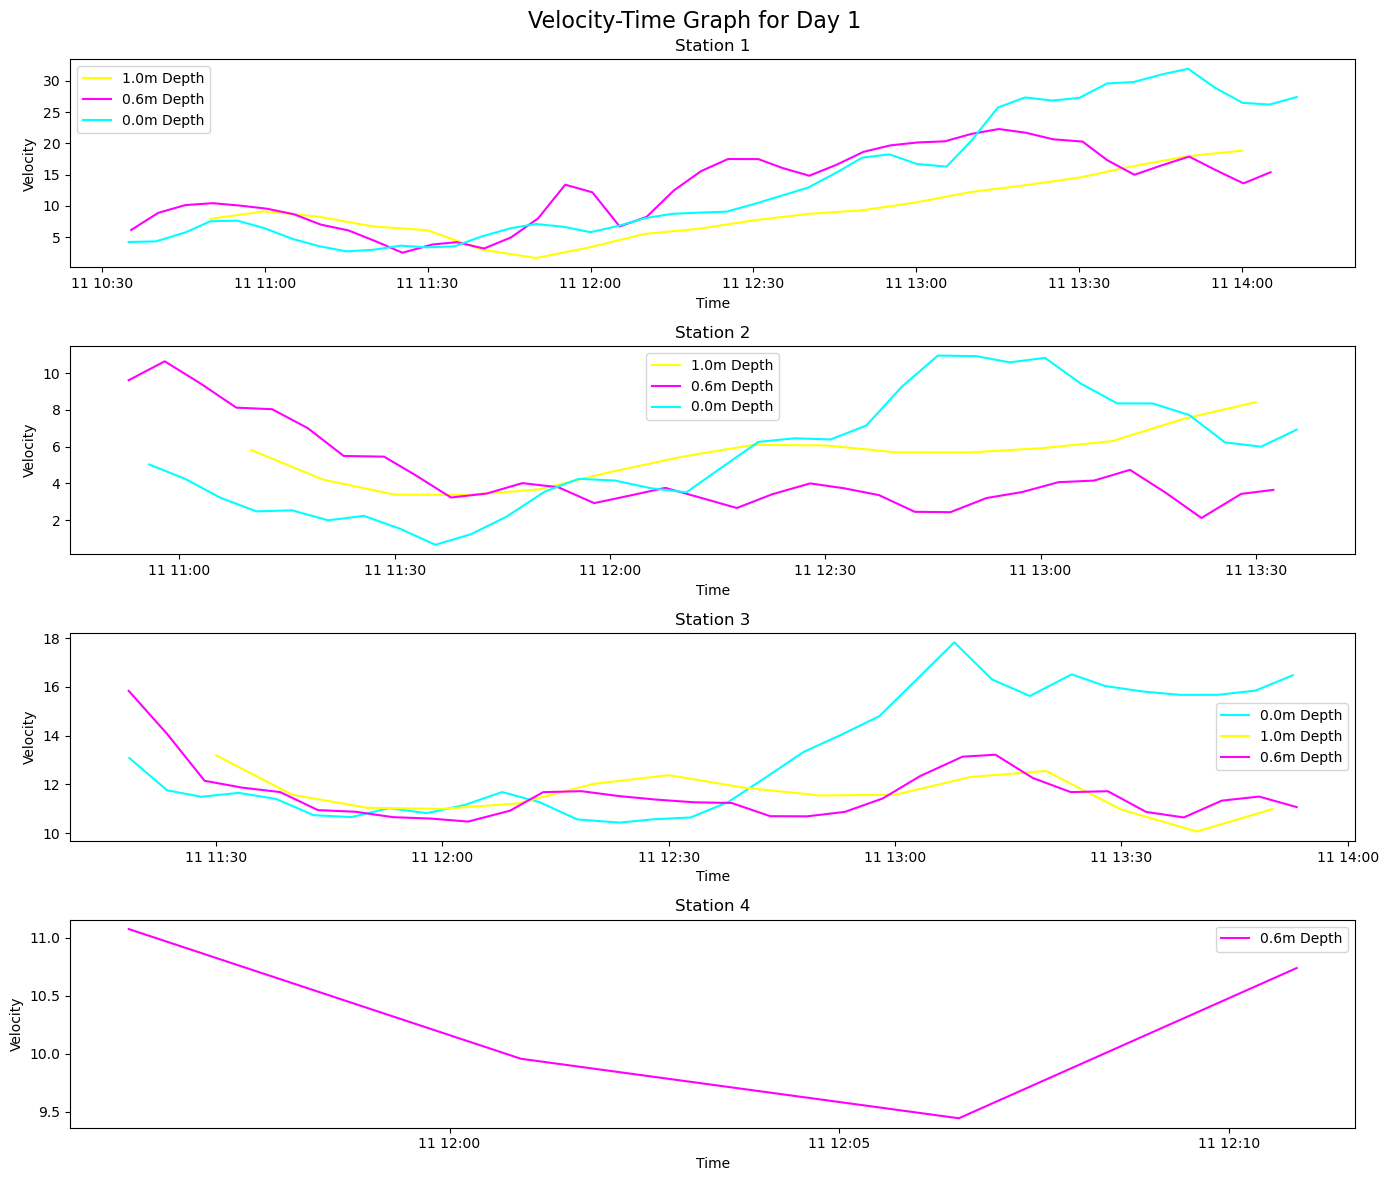

In [63]:
D1.plot_lineplot(saving_path="./Plots/Day1/")

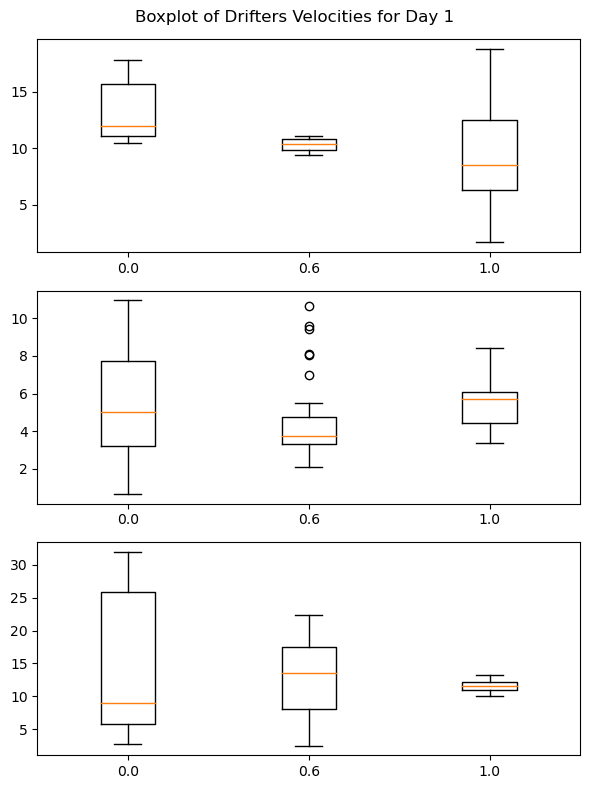

In [64]:
D1.plot_boxplot(saving_path="./Plots/Day1/")

### Day 2

In [65]:
# Define the Day 1 Parameters
working_dir = "Data/2022/Day2"

# Create an Instance of the Drifter Class
D2 = Drifters("Day 2")

# Read the Data
D2.read_data(f"{working_dir}/drifters/")

# Visualize the first 3 items of the modified data
key = "277"
D2.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-12 07:20:00,43.10380,5.91181
1,2022-10-12 07:30:00,43.08799,5.92791
2,2022-10-12 07:40:00,43.08133,5.95918


In [66]:
# Read the Logsheet
D2.read_logsheet(f"{working_dir}/drifters-logsheet.csv")

D2.logsheet

,Station,Name,DrogDepth,DepLong,DepLat,RecovLong,RecovLat,DepDateTime,RecovDateTime
0,1.0,274.0,1.0,5°58.363,43°4.655,5.0°57.564,43.0°4.783,2022-10-12 09:47:00,2022-10-12 12:40:00
1,1.0,8436.0,0.0,5°58.363,43°4.655,5.0°57.185,43.0°4.708,2022-10-12 09:47:00,2022-10-12 12:32:00
2,1.0,6439.0,0.6,5°58.363,43°4.655,5.0°57.571,43.0°4.803,2022-10-12 09:47:00,2022-10-12 12:42:00
3,2.0,273.0,1.0,5°59.055,43°4.723,5.0°57.743,43.0°5.145,2022-10-12 09:59:00,2022-10-12 14:03:00
4,2.0,7230.0,0.6,5°59.055,43°4.723,5.0°57.955,43.0°5.144,2022-10-12 09:59:00,2022-10-12 13:59:00
5,2.0,119.0,0.0,5°59.055,43°4.723,5.0°56.777,43.0°5.185,2022-10-12 09:59:00,2022-10-12 14:12:00
6,3.0,277.0,1.0,5°59.956,43°4.809,5.0°58.864,43.0°5.309,2022-10-12 10:16:00,2022-10-12 13:45:00
7,3.0,2052.0,0.0,5°59.956,43°4.809,5.0°58.161,43.0°5.361,2022-10-12 10:16:00,2022-10-12 13:52:00
8,3.0,3368.0,0.6,5°59.956,43°4.809,5.0°59.034,43.0°5.274,2022-10-12 10:16:00,2022-10-12 13:43:00


In [67]:
# Shift time for the data
D2.time_shift(2)

# Visualize the first 3 items of the modified data
D2.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-12 09:20:00,43.10380,5.91181
1,2022-10-12 09:30:00,43.08799,5.92791
2,2022-10-12 09:40:00,43.08133,5.95918


In [68]:
# Extract Valid Data
D2.extract_data()

# Visualize the first 3 items of the modified data
D2.data[key].head(3)

,DateTime,Latitude,Longitude
6,2022-10-12 10:20:00,43.08001,5.99907
7,2022-10-12 10:30:00,43.07988,5.99818
8,2022-10-12 10:40:00,43.07974,5.99750


In [69]:
# Compute Velocity
D2.compute_velocity(mov_avg=2)

# Visualize the first 3 items of the modified data
D2.data[key].head(3)

,DateTime,Latitude,Longitude,Velocity
0,2022-10-12 10:40:00,43.07974,5.99750,10.916473
1,2022-10-12 10:50:00,43.07973,5.99668,10.246860
2,2022-10-12 11:00:00,43.07993,5.99578,11.773512


In [70]:
D2.plot_trajectories(saving_path="./Plots/Day2/")
D2.map

43.07578 43.08921 5.95369 5.99841


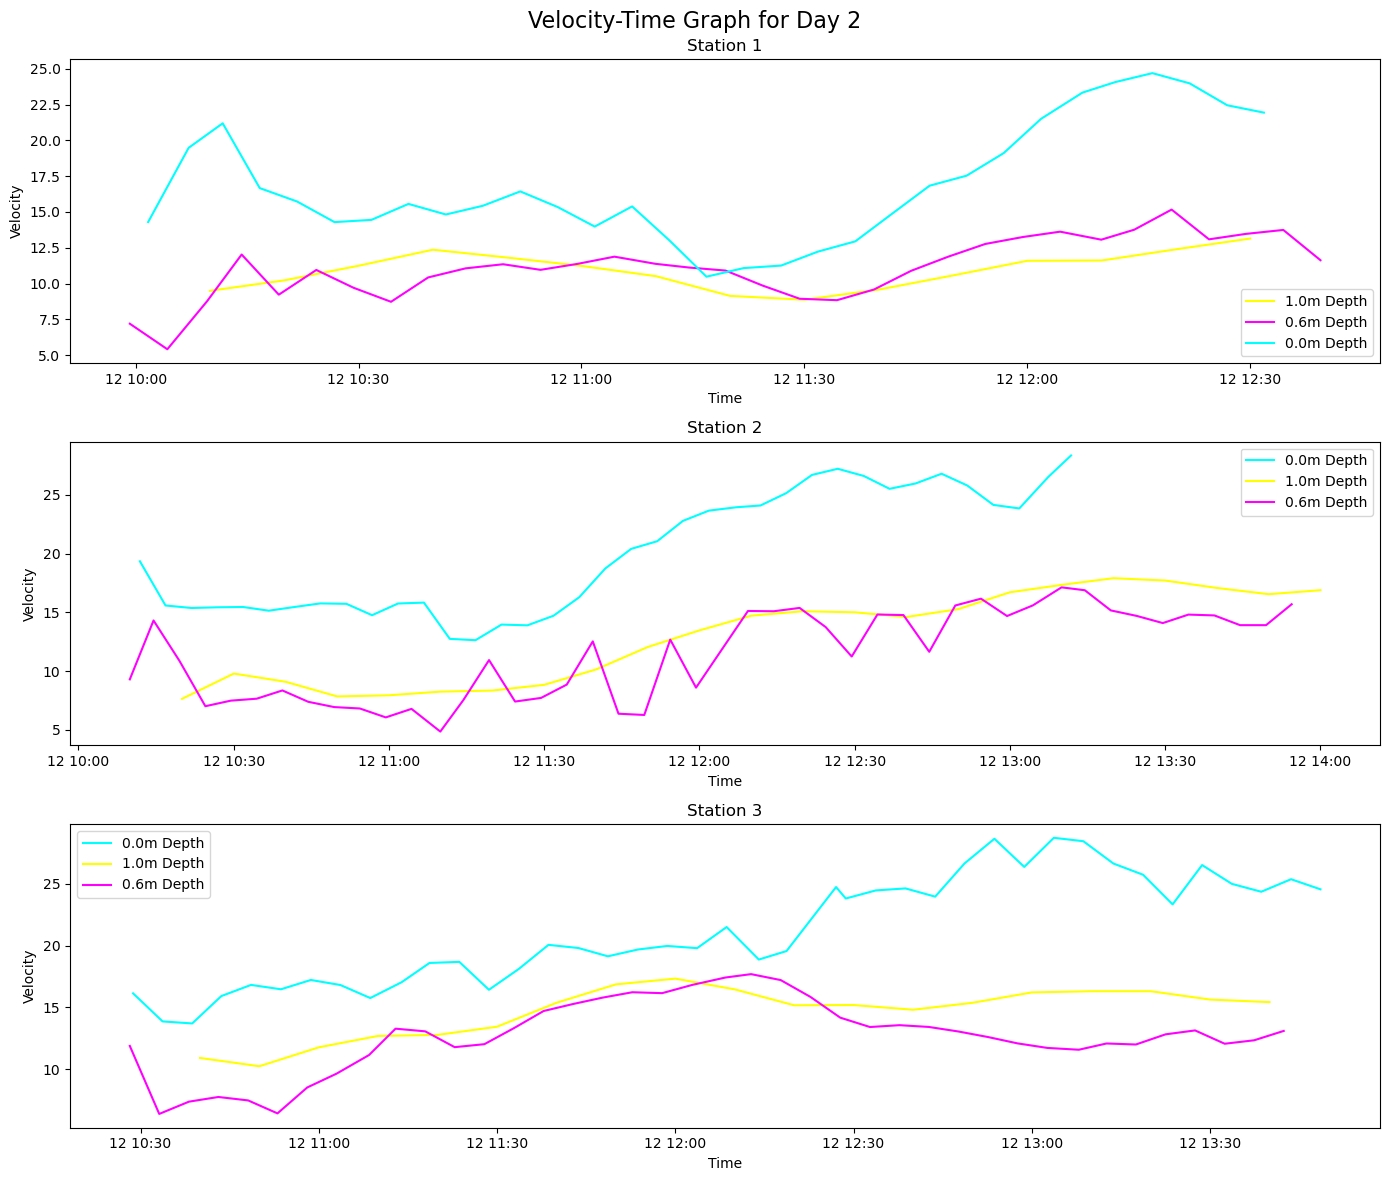

In [71]:
D2.plot_lineplot(saving_path="./Plots/Day2/")

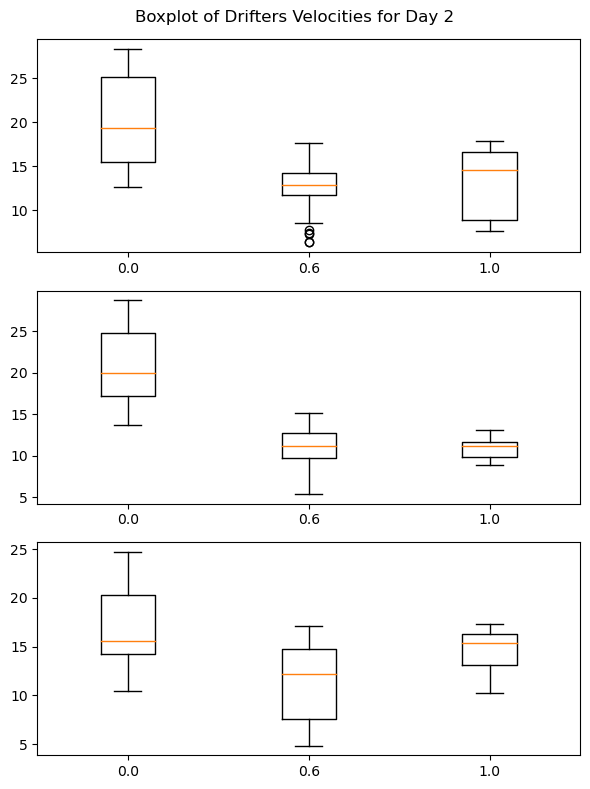

In [72]:
D2.plot_boxplot(saving_path="./Plots/Day2/")

### Day 3

In [73]:
# Define the Day 1 Parameters
working_dir = "Data/2022/Day3"

# Create an Instance of the Drifter Class
D3 = Drifters("Day 3")

# Read the Data
D3.read_data(f"{working_dir}/drifters/")

# Read the Logsheet
D3.read_logsheet(f"{working_dir}/drifters-logsheet.csv")

key = "274"
D3.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-13 07:10:00,43.10471,5.88793
1,2022-10-13 07:20:00,43.10431,5.91185
2,2022-10-13 07:30:00,43.08840,5.93095


In [74]:
D3.data_info.keys()

dict_keys(['0119', '2052', '273', '274', '279', '3368', '6439', '7230', '8436', '9666'])

In [75]:
D3.logsheet

,Station,Name,DrogDepth,DepLong,DepLat,RecovLong,RecovLat,DepDateTime,RecovDateTime
0,1,3368,0.0,005°59.972,"43°4,813",005°59.593,43°5.133,2022-10-13 09:54:00,2022-10-13 14:39:00
1,1,274,1.0,005°59.972,"43°4,813",005°59.716,43°5.224,2022-10-13 09:54:00,2022-10-13 14:41:00
2,1,2052,0.0,005°59.972,"43°4,813",006°0.041,43°5.421,2022-10-13 09:54:00,2022-10-13 14:45:00
3,2,279,1.0,005°58.987,43°4.686,005°58.501,43°4.335,2022-10-13 10:03:00,2022-10-13 13:58:00
4,2,6439,0.6,005°58.987,43°4.686,005°58.499,43°4.402,2022-10-13 10:03:00,2022-10-13 13:55:00
5,2,8436,0.0,005°58.987,43°4.686,005°58.677,43°4.495,2022-10-13 10:03:00,2022-10-13 13:52:00
6,3,119,0.6,005°58.416,43°4.669,005°58.209,43°4.851,2022-10-13 10:21:00,2022-10-13 14:30:00
7,3,7230,0.0,005°58.416,43°4.669,005°58.569,43°4.882,2022-10-13 10:21:00,2022-10-13 14:22:00
8,3,273,1.0,005°58.416,43°4.669,005°58.265,43°4.949,2022-10-13 10:21:00,2022-10-13 14:24:00
9,4,9666,0.6,6°0.678,42°59.547,5.0°45.322,42.0°58.672,2022-10-12 10:55:00,2022-10-13 11:39:00


In [76]:
# Shift time for the data
D3.time_shift(2)

D3.data[key].head(3)

,DateTime,Latitude,Longitude
0,2022-10-13 09:10:00,43.10471,5.88793
1,2022-10-13 09:20:00,43.10431,5.91185
2,2022-10-13 09:30:00,43.08840,5.93095


In [77]:
# Extract Valid Data
D3.extract_data()
D3.data[key].head(3)

,DateTime,Latitude,Longitude
5,2022-10-13 10:00:00,43.08005,5.99927
6,2022-10-13 10:10:00,43.08000,5.99864
7,2022-10-13 10:20:00,43.07993,5.99807


In [78]:
# Compute Velocity
D3.compute_velocity(mov_avg=2)
D3.data[key].head(3)

,DateTime,Latitude,Longitude,Velocity
0,2022-10-13 10:20:00,43.07993,5.99807,8.197464
1,2022-10-13 10:30:00,43.07978,5.99733,9.097545
2,2022-10-13 10:40:00,43.07963,5.99649,11.049024


In [79]:
D3.data_info.keys()

dict_keys(['0119', '2052', '273', '274', '279', '3368', '6439', '7230', '8436', '9666'])

In [80]:
D3.data.pop("9666")
D3.data_info.pop("9666")
D3.plot_trajectories(saving_path="./Plots/Day3/")
D3.map

43.07213 43.09039 5.96489 6.0007


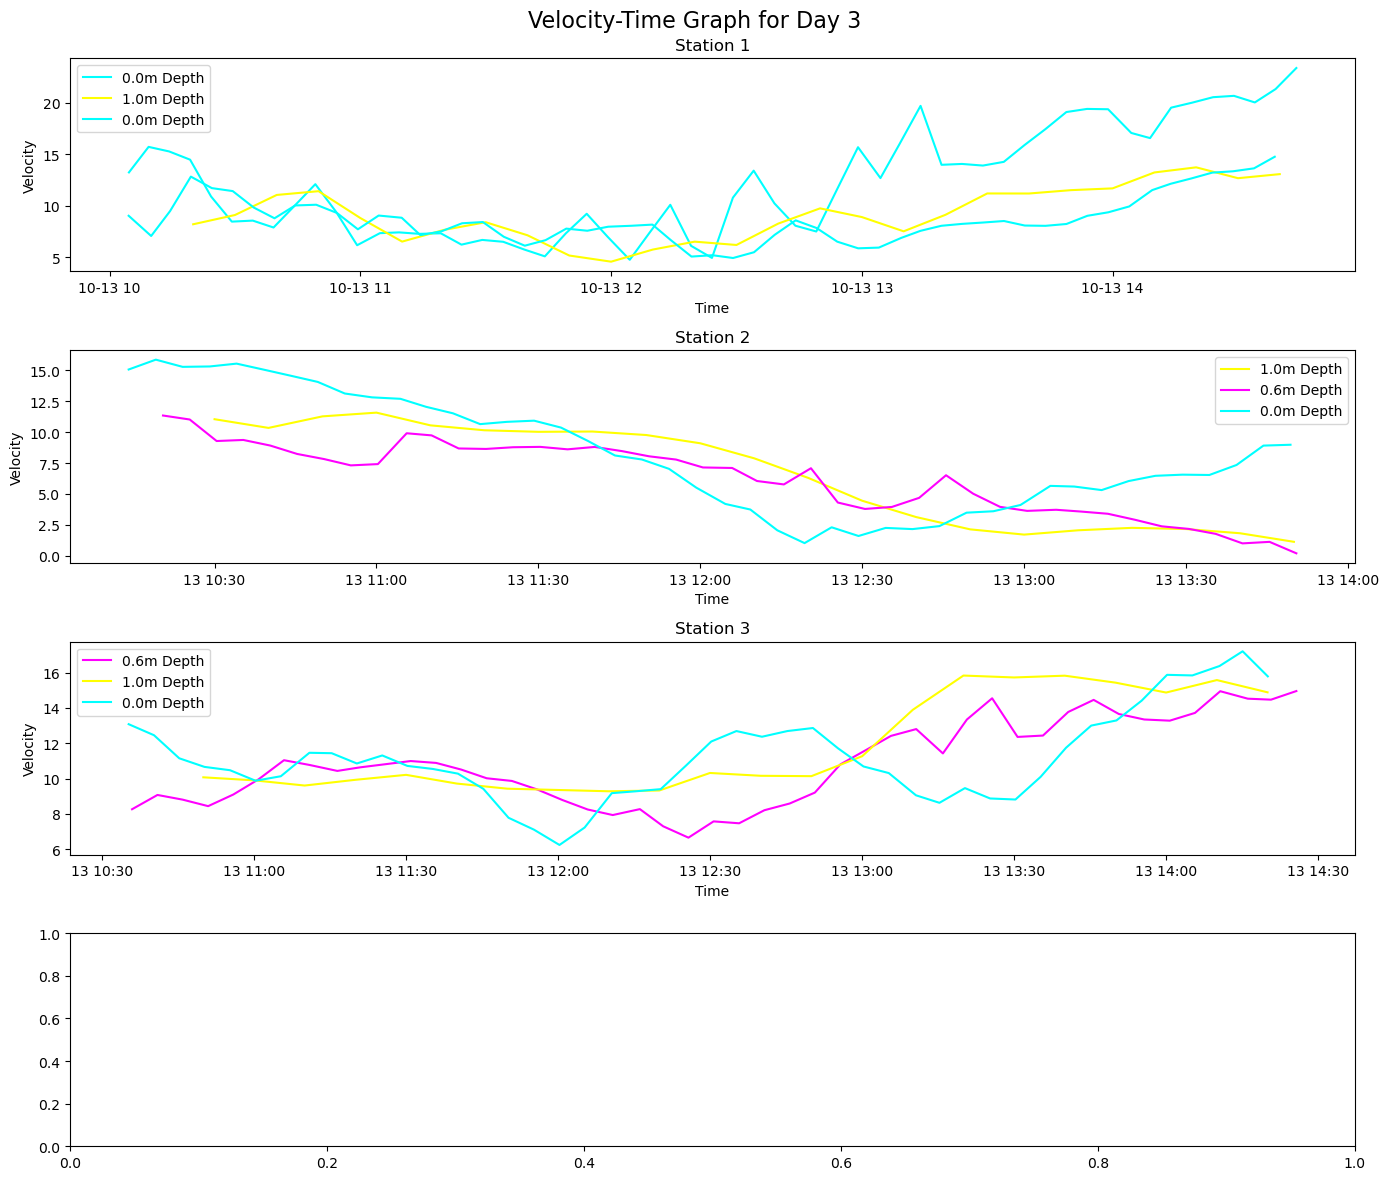

In [81]:
D3.plot_lineplot(saving_path="./Plots/Day3/")

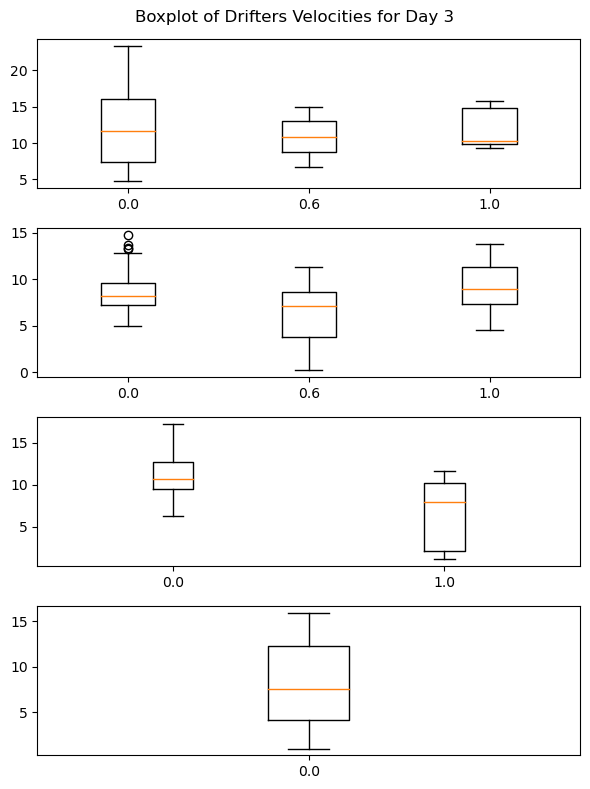

In [82]:
D3.plot_boxplot(saving_path="./Plots/Day3/")

## Exporting Cleaned Data

In [83]:
clean_data_path = "./CleanDriftersData/"
D1.export_cleaned_data(clean_data_path + "Day1")
D2.export_cleaned_data(clean_data_path + "Day2")
D3.export_cleaned_data(clean_data_path + "Day3")